In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools 
from statsforecast import StatsForecast
from statsforecast.models import SeasonalWindowAverage

In [2]:
df_brent = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view')

df_brent = df_brent[2]
df_brent = pd.DataFrame(df_brent)

df_brent.columns = ['Data', 'Preço Brent FOB (US$/barril)']
df_brent = df_brent.drop([0, 1])

df_brent['Data'] = pd.to_datetime(df_brent['Data'], format='%d/%m/%Y')

df_brent['Preço Brent FOB (US$/barril)_Corrigido'] = df_brent['Preço Brent FOB (US$/barril)'].apply(lambda x: f"{str(x)[:-2]}.{str(x)[-2:]}")
df_brent['Preço Brent FOB (US$/barril)_Corrigido'] = df_brent['Preço Brent FOB (US$/barril)_Corrigido'].astype(float)
df_brent.drop(columns=['Preço Brent FOB (US$/barril)'], inplace=True)


<Axes: title={'center': 'Preço Brent FOB (US$/barril)'}, xlabel='Data'>

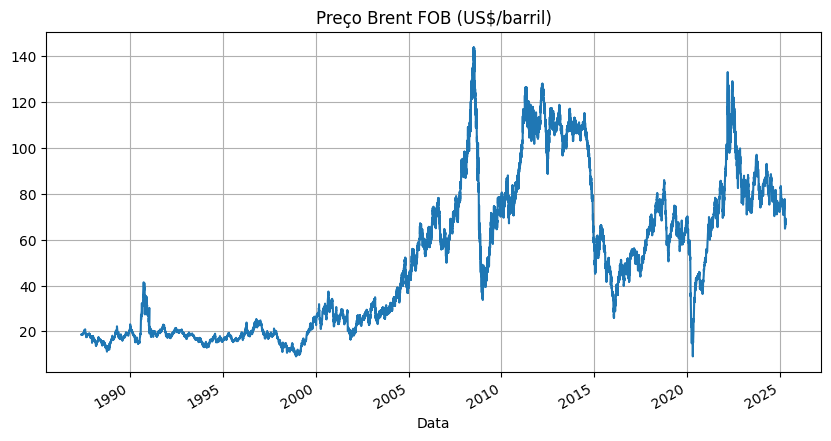

In [3]:
df_brent.plot(x='Data', y='Preço Brent FOB (US$/barril)_Corrigido', title='Preço Brent FOB (US$/barril)', figsize=(10, 5), grid=True, legend=False)

In [29]:
# Treinando o modelo em Naive + Seasonal + media movel

# Tratando os dados para o modelo

df_brent_SWM = df_brent.copy()
df_brent_SWM = df_brent_SWM[df_brent_SWM['Data'] <= '2024-12-31']
df_brent_SWM = df_brent_SWM.rename(columns={'Data': 'ds', 'Preço Brent FOB (US$/barril)_Corrigido': 'y'})
df_brent_SWM['unique_id'] = 1

# SWN = SeasonalWindowAverage

Brent_SWN = StatsForecast(models=[SeasonalWindowAverage(season_length=7,window_size=2)], freq='D')
Brent_SWN.fit(df_brent_SWM)

Brent_SWN_forecast = Brent_SWN.predict(h=90)

Brent_SWN_forecast = df_brent.merge(
    Brent_SWN_forecast,
    left_on='Data',
    right_on='ds',
    how='inner'
)

Brent_SWN_forecast = Brent_SWN_forecast.drop(columns=['unique_id', 'ds'])

# Calculando o WMAPE
wmape = np.sum(np.abs(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'] - Brent_SWN_forecast['SeasWA'])) / np.sum(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'])
print(f"WMAPE: {wmape:.4%}")

WMAPE: 4.0459%


In [36]:
# Treinando o modelo em Naive + Seasonal + media movel

# Tratando os dados para o modelo

df_brent_SWM = df_brent.copy()
df_brent_SWM = df_brent_SWM[df_brent_SWM['Data'] <= '2024-12-31']
df_brent_SWM = df_brent_SWM.rename(columns={'Data': 'ds', 'Preço Brent FOB (US$/barril)_Corrigido': 'y'})
df_brent_SWM['unique_id'] = 1

###

# --- Definindo o Grid de Hiperparâmetros ---
# Você pode ajustar os intervalos conforme seu interesse
param_grid = {
    'season_length': list(range(1, 50)),  # teste diferentes comprimentos sazonais
    'window_size': list(range(1, 50))         # teste diferentes tamanhos de janela
}

# Gerando todas as combinações possíveis
all_params = [dict(zip(param_grid.keys(), values))
              for values in itertools.product(*param_grid.values())]

results = []  # lista para guardar os resultados de cada combinação

# --- Loop do Grid Search ---
for params in all_params:
    print(f"Testando parâmetros: {params}")
    
    # Instancia o modelo SeasonalWindowAverage com os hiperparâmetros atuais
    model = SeasonalWindowAverage(
        window_size=params['window_size'],
        season_length=params['season_length']
    )
    
    # Instancia o StatsForecast com o modelo e frequência diária
    Brent_SWN = StatsForecast(models=[model], freq='D')
    
    # Ajusta o modelo com os dados de treino
    Brent_SWN.fit(df_brent_SWM)
    Brent_SWN_forecast = Brent_SWN.predict(h=90)
    Brent_SWN_forecast = df_brent.merge(
        Brent_SWN_forecast,
        left_on='Data',
        right_on='ds',
        how='inner'
    )

    Brent_SWN_forecast = Brent_SWN_forecast.drop(columns=['unique_id', 'ds'])

    # Calculando o WMAPE
    wmape = np.sum(np.abs(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'] - Brent_SWN_forecast['SeasWA'])) / np.sum(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'])
    print(f"Parâmetros: {params} -> WMAPE: {wmape:.4%}\n")
    results.append({
        'season_length': params['season_length'],
        'window_size': params['window_size'],
        'WMAPE': wmape
    })

# --- Criando uma Tabela com os Resultados ---
results_table = pd.DataFrame(results)
results_table.sort_values('WMAPE', inplace=True)

# --- Criando uma Tabela com os Resultados ---
results_table = pd.DataFrame(results)
results_table.sort_values('WMAPE', inplace=True)

# Converter a coluna 'WMAPE' para string formatada como porcentagem (com 2 casas decimais)
results_table['WMAPE'] = results_table['WMAPE'].apply(lambda x: "{:.2%}".format(x))

print("Resultados da Otimização via Grid Search:")
print(results_table.to_string(index=False))

Testando parâmetros: {'season_length': 1, 'window_size': 1}
Parâmetros: {'season_length': 1, 'window_size': 1} -> WMAPE: 3.5602%

Testando parâmetros: {'season_length': 1, 'window_size': 2}
Parâmetros: {'season_length': 1, 'window_size': 2} -> WMAPE: 3.6474%

Testando parâmetros: {'season_length': 1, 'window_size': 3}
Parâmetros: {'season_length': 1, 'window_size': 3} -> WMAPE: 3.7590%

Testando parâmetros: {'season_length': 1, 'window_size': 4}
Parâmetros: {'season_length': 1, 'window_size': 4} -> WMAPE: 3.8501%

Testando parâmetros: {'season_length': 1, 'window_size': 5}
Parâmetros: {'season_length': 1, 'window_size': 5} -> WMAPE: 3.9065%

Testando parâmetros: {'season_length': 1, 'window_size': 6}
Parâmetros: {'season_length': 1, 'window_size': 6} -> WMAPE: 4.0825%

Testando parâmetros: {'season_length': 1, 'window_size': 7}
Parâmetros: {'season_length': 1, 'window_size': 7} -> WMAPE: 4.1196%

Testando parâmetros: {'season_length': 1, 'window_size': 8}
Parâmetros: {'season_length': 

In [37]:
print("Resultados da Otimização via Grid Search:")
print(results_table.to_string(index=False))

Resultados da Otimização via Grid Search:
 season_length  window_size  WMAPE
            22            5  3.31%
            21            5  3.32%
            44           29  3.33%
            17            6  3.34%
             8           12  3.34%
            37            3  3.35%
             8           13  3.36%
            34           37  3.38%
            11           10  3.38%
            33           38  3.38%
            34           36  3.38%
             8           14  3.39%
            33           39  3.39%
            31           40  3.39%
            11            9  3.39%
            47           27  3.40%
             4           25  3.40%
             4           26  3.40%
            25           49  3.40%
             4           27  3.40%
            37           33  3.41%
            47           28  3.41%
             4           28  3.41%
             3           34  3.41%
             6           17  3.41%
            34           38  3.41%
            3

In [40]:
# Treinando o modelo em Naive + Seasonal + media movel

# Tratando os dados para o modelo

df_brent_SWM = df_brent.copy()
df_brent_SWM = df_brent_SWM[df_brent_SWM['Data'] <= '2024-12-31']
df_brent_SWM = df_brent_SWM.rename(columns={'Data': 'ds', 'Preço Brent FOB (US$/barril)_Corrigido': 'y'})
df_brent_SWM['unique_id'] = 1

# SWN = SeasonalWindowAverage

Brent_SWN = StatsForecast(models=[SeasonalWindowAverage(season_length=22,window_size=5)], freq='D')
Brent_SWN.fit(df_brent_SWM)

Brent_SWN_forecast = Brent_SWN.predict(h=90)

Brent_SWN_forecast = df_brent.merge(
    Brent_SWN_forecast,
    left_on='Data',
    right_on='ds',
    how='inner'
)

Brent_SWN_forecast = Brent_SWN_forecast.drop(columns=['unique_id', 'ds'])

# Calculando o WMAPE
wmape = np.sum(np.abs(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'] - Brent_SWN_forecast['SeasWA'])) / np.sum(Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'])
print(f"WMAPE: {wmape:.4%}")

WMAPE: 3.3052%


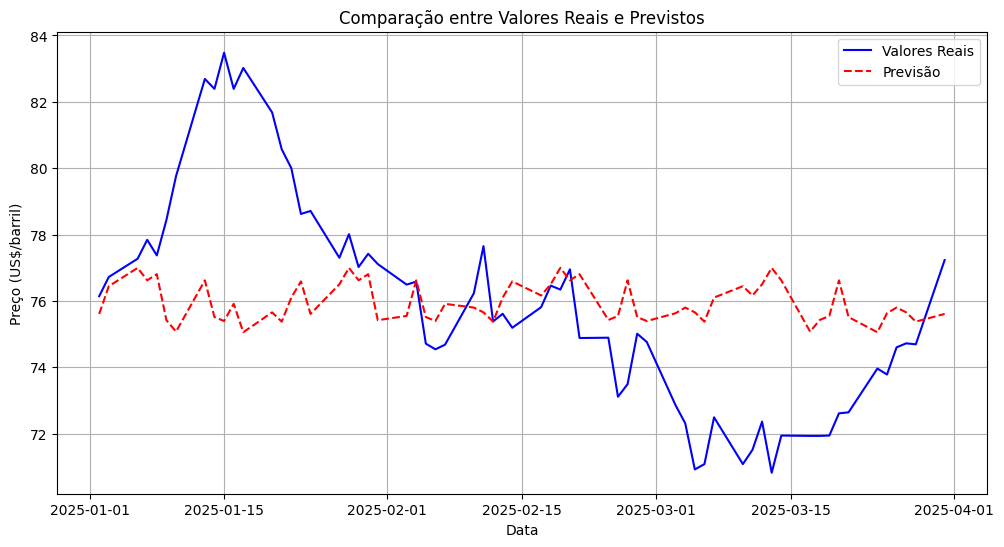

In [41]:

# Converter a coluna 'Data' para datetime caso ainda não esteja e ordenar o DataFrame
Brent_SWN_forecast.sort_values('Data', inplace=True)

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(Brent_SWN_forecast['Data'], 
         Brent_SWN_forecast['Preço Brent FOB (US$/barril)_Corrigido'], 
         label='Valores Reais', color='blue')
plt.plot(Brent_SWN_forecast['Data'], 
         Brent_SWN_forecast['SeasWA'], 
         label='Previsão', color='red', linestyle='--')

plt.xlabel('Data')
plt.ylabel('Preço (US$/barril)')
plt.title('Comparação entre Valores Reais e Previstos')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
Brent_SWN_forecast

,Data,Preço Brent FOB (US$/barril)_Corrigido,SeasWA
0,2025-03-31,77.23,68.166327
1,2025-03-28,74.69,68.436327
2,2025-03-27,74.72,68.198163
3,2025-03-26,74.60,68.202245
4,2025-03-25,73.78,68.414082
...,...,...,...
58,2025-01-08,77.37,67.527551
59,2025-01-07,77.84,67.521224
60,2025-01-06,77.27,67.517551
61,2025-01-03,76.72,67.514898
